###Data Dictionaries

Candidates table --> http://www.opensecrets.org/resources/datadictionary/Data%20Dictionary%20Candidates%20Data.htm

PACs table --> http://www.opensecrets.org/resources/datadictionary/Data%20Dictionary%20for%20PAC%20to%20Cands%20Data.htm

In [115]:
import pandas as pd
import numpy as np
from patsy import dmatrices, dmatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
# load tables
cands = pd.read_table('cands12_copy3.txt', delimiter=',', na_values=[' ', '    '])
pacs = pd.read_table('pacs12_copy.txt', delimiter=',')

In [61]:
cands.head()

,cycle,fec_cand_id,cid,first_last_p,party,distid_run,distid_cur,cur_cand,cycle_cand,crpico,recip_code,no_pacs,Unnamed: 12
0,2012,H2NC08219,N00034999,Antonio Blue (D),D,NC08,NaN,NaN,Y,C,DC,NaN,NaN
1,2012,H2VI00082,N00035000,Stacey Plaskett (D),D,VI00,NaN,NaN,Y,C,DN,NaN,NaN
2,2012,S2NY00317,N00035001,Tim Sweet (I),I,NYS1,NaN,Y,Y,C,3L,NaN,NaN
3,2012,P20005104,N00035002,Maura Deluca (3),3,PRES,NaN,NaN,NaN,NaN,3N,NaN,NaN
4,2012,P20005120,N00035003,Colin David Teberg (U),U,PRES,NaN,NaN,NaN,NaN,UN,NaN,NaN


In [62]:
pacs.head()

,cycle,fec_rec_no,pac_id,cid,amount,date,real_code,type,di,fec_cand_id
0,2012,4101720121167459916,C00279380,N00027694,1500,09/25/2012,LT500,24K,D,S6MO00305
1,2012,4020120121150250973,C00279455,N00027510,1000,04/01/2011,H4300,24K,D,H6CO07023
2,2012,4121720121176010367,C00347385,N00001861,1000,09/20/2012,C4000,24K,D,H6CA24048
3,2012,4042520121155267132,C00034272,N00004227,2000,03/27/2012,A2300,24K,D,H4IA05102
4,2012,4111520121172245411,C00000729,N00007335,1000,10/10/2012,H1400,24K,D,H8CA12098


In [63]:
cands = cands.drop(cands.columns[-1], axis=1) #drop extra column

In [64]:
cands.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5952 entries, 0 to 5951
Data columns (total 12 columns):
cycle           5952 non-null int64
fec_cand_id     5952 non-null object
cid             5952 non-null object
first_last_p    5952 non-null object
party           5952 non-null object
distid_run      5952 non-null object
distid_cur      569 non-null object
cur_cand        1409 non-null object
cycle_cand      2984 non-null object
crpico          3266 non-null object
recip_code      5952 non-null object
no_pacs         7 non-null object
dtypes: int64(1), object(11)
memory usage: 604.5+ KB


In [65]:
pacs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394542 entries, 0 to 394541
Data columns (total 10 columns):
cycle          394542 non-null int64
fec_rec_no     394542 non-null int64
pac_id         394542 non-null object
cid            394461 non-null object
amount         394542 non-null int64
date           394525 non-null object
real_code      394542 non-null object
type           394542 non-null object
di             394542 non-null object
fec_cand_id    394540 non-null object
dtypes: int64(3), object(7)
memory usage: 33.1+ MB


In [66]:
#make new column 'race_type'
def group_titles(x):
    if 'PRES' in x:
        return 'PRES'
    elif x.find('S') == 2:
        return 'SEN'
    else:
        return 'HOUSE'

In [67]:
cands['race_type'] = cands.distid_run.apply(group_titles)

In [68]:
cands.head()

,cycle,fec_cand_id,cid,first_last_p,party,distid_run,distid_cur,cur_cand,cycle_cand,crpico,recip_code,no_pacs,race_type
0,2012,H2NC08219,N00034999,Antonio Blue (D),D,NC08,NaN,NaN,Y,C,DC,NaN,HOUSE
1,2012,H2VI00082,N00035000,Stacey Plaskett (D),D,VI00,NaN,NaN,Y,C,DN,NaN,HOUSE
2,2012,S2NY00317,N00035001,Tim Sweet (I),I,NYS1,NaN,Y,Y,C,3L,NaN,SEN
3,2012,P20005104,N00035002,Maura Deluca (3),3,PRES,NaN,NaN,NaN,NaN,3N,NaN,PRES
4,2012,P20005120,N00035003,Colin David Teberg (U),U,PRES,NaN,NaN,NaN,NaN,UN,NaN,PRES


In [69]:
# make column 'state' for race location
def states(x):
    if not 'PRES' in x:
        return x[0:2]
    
cands['state'] = cands.distid_run.apply(states)

In [70]:
# make column 'district' for seat run for
def district(x):
    if not 'PRES' in x:
        return x[2:]

cands['district'] = cands.distid_run.apply(district)

In [71]:
# the last letter in 'recip_code' indicates win or lose, pull that out first, then make 'win' column
cands['result'] = cands['recip_code'].str[1]

In [72]:
def win(x):
    if 'L' in x:
        return 0
    elif 'W' in x:
        return 1

cands['win'] = cands['result'].apply(win)

In [73]:
# 'no_pacs' might not be a useful column since only 7 candidates elected not to receive donations from PACS
# but nevertheless fill NaNs to be 0, set 'Y' == 1 in new column 'no_pacs_bin'
cands['no_pacs_bin'] = cands.no_pacs.apply(lambda x: 1 if x == 'Y' else int(0))

In [74]:
# distid_cur == NaN if non incumbent. fill nan == 0, make new incumbent column
cands['distid_cur'] = cands.distid_cur.fillna(0)
cands['incumbent'] = cands.distid_cur.apply(lambda x: 1 if x != 0 else int(0))

In [75]:
# since the cycle is always 2012, can drop that column
# and cid column (campaign id), since no information contained there
cands = cands.drop(cands.columns[[0,2]], axis=1)

In [76]:
cands.head()

,fec_cand_id,first_last_p,party,distid_run,distid_cur,cur_cand,cycle_cand,crpico,recip_code,no_pacs,race_type,state,district,result,win,no_pacs_bin,incumbent
0,H2NC08219,Antonio Blue (D),D,NC08,0,NaN,Y,C,DC,NaN,HOUSE,NC,08,C,NaN,0,0
1,H2VI00082,Stacey Plaskett (D),D,VI00,0,NaN,Y,C,DN,NaN,HOUSE,VI,00,N,NaN,0,0
2,S2NY00317,Tim Sweet (I),I,NYS1,0,Y,Y,C,3L,NaN,SEN,NY,S1,L,0,0,0
3,P20005104,Maura Deluca (3),3,PRES,0,NaN,NaN,NaN,3N,NaN,PRES,None,None,N,NaN,0,0
4,P20005120,Colin David Teberg (U),U,PRES,0,NaN,NaN,NaN,UN,NaN,PRES,None,None,N,NaN,0,0


In [77]:
#get total amount donated to each candidate by all PACs
pacs_grouped = pacs.groupby('fec_cand_id').sum()

In [78]:
pacs_grouped.head()

,cycle,fec_rec_no,amount
fec_cand_id,,,
H0AK00089,2012,4.092620e+18,-1000
H0AL02087,802788,1.608374e+21,535065
H0AL05163,694140,1.392243e+21,469727
H0AL05197,4024,6.164040e+18,5391
H0AL07060,2012,4.031620e+18,-1500


In [79]:
# can drop cycle and fec_rec_no (receipt) columns
pacs_grouped = pacs_grouped.drop(pacs_grouped.columns[[0,1]], axis=1)

In [80]:
#get number of times any PAC donated to each candidate
pacs_total = pacs.groupby('fec_cand_id').count()

In [81]:
pacs_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1785 entries, H0AK00089 to S8WV00101
Data columns (total 9 columns):
cycle         1785 non-null int64
fec_rec_no    1785 non-null int64
pac_id        1785 non-null int64
cid           1785 non-null int64
amount        1785 non-null int64
date          1785 non-null int64
real_code     1785 non-null int64
type          1785 non-null int64
di            1785 non-null int64
dtypes: int64(9)
memory usage: 139.5+ KB


In [82]:
# the higher the count of pac_id, the more times a PAC donated to a candidate. This column cand be used 
# as a proxy for race length, since the more times a PAC donated the longer the race went
# drop all columns except pac_id before join
pacs_total = pacs_total.drop(pacs_total.columns[[0,1,3,4,5,6,7,8]], axis=1)

In [83]:
pacs_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1785 entries, H0AK00089 to S8WV00101
Data columns (total 1 columns):
pac_id    1785 non-null int64
dtypes: int64(1)
memory usage: 27.9+ KB


In [84]:
#get unique number of PACs that donated to each candidate
pac_unique = pacs.groupby('fec_cand_id').pac_id.nunique()

In [85]:
pac_unique.head()

fec_cand_id
H0AK00089      1
H0AL02087    201
H0AL05163    159
H0AL05197      2
H0AL07060      1
Name: pac_id, dtype: int64

In [86]:
# join new data frames/columns into 'full' data frame
full = cands.join(pacs_grouped, on='fec_cand_id', how='left')
full = full.join(pac_unique, on='fec_cand_id', how='left')
full = full.join(pacs_total, on='fec_cand_id', how='left', lsuffix='_unique', rsuffix='_total')

In [87]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5952 entries, 0 to 5951
Data columns (total 20 columns):
fec_cand_id      5952 non-null object
first_last_p     5952 non-null object
party            5952 non-null object
distid_run       5952 non-null object
distid_cur       5952 non-null object
cur_cand         1409 non-null object
cycle_cand       2984 non-null object
crpico           3266 non-null object
recip_code       5952 non-null object
no_pacs          7 non-null object
race_type        5952 non-null object
state            5365 non-null object
district         5365 non-null object
result           5952 non-null object
win              2584 non-null float64
no_pacs_bin      5952 non-null int64
incumbent        5952 non-null int64
amount           1743 non-null float64
pac_id_unique    1743 non-null float64
pac_id_total     1743 non-null float64
dtypes: float64(4), int64(2), object(14)
memory usage: 976.5+ KB


In [88]:
#fill NaNs where NaN actually just equals 0
full['win'] = full.win.fillna(0)
full['amount'] = full.amount.fillna(0)
full['pac_id_unique'] = full.pac_id_unique.fillna(0)
full['pac_id_total'] = full.pac_id_total.fillna(0)

In [89]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5952 entries, 0 to 5951
Data columns (total 20 columns):
fec_cand_id      5952 non-null object
first_last_p     5952 non-null object
party            5952 non-null object
distid_run       5952 non-null object
distid_cur       5952 non-null object
cur_cand         1409 non-null object
cycle_cand       2984 non-null object
crpico           3266 non-null object
recip_code       5952 non-null object
no_pacs          7 non-null object
race_type        5952 non-null object
state            5365 non-null object
district         5365 non-null object
result           5952 non-null object
win              5952 non-null float64
no_pacs_bin      5952 non-null int64
incumbent        5952 non-null int64
amount           5952 non-null float64
pac_id_unique    5952 non-null float64
pac_id_total     5952 non-null float64
dtypes: float64(4), int64(2), object(14)
memory usage: 976.5+ KB


In [90]:
full.corr()
# Winning IS NOT strongly correlated with amount donated, which is very important as I believe it will be the
# most important feature in my model. Note that incumbency is strongly correlated with winning, as is the 
# number of unique PACs that donate to a candidate

,win,no_pacs_bin,incumbent,amount,pac_id_unique,pac_id_total
win,1.000000,0.024952,0.725475,0.096465,0.708010,0.258386
no_pacs_bin,0.024952,1.000000,0.055529,-0.001777,-0.007758,-0.003260
incumbent,0.725475,0.055529,1.000000,0.093234,0.758505,0.267309
amount,0.096465,-0.001777,0.093234,1.000000,0.198954,0.919135
pac_id_unique,0.708010,-0.007758,0.758505,0.198954,1.000000,0.438943
pac_id_total,0.258386,-0.003260,0.267309,0.919135,0.438943,1.000000


In [91]:
#plot number unique PACs donating to candidates vs. total number of donations to candidates from all PACs
full.plot(kind='scatter', x='pac_id_unique', y='pac_id_total')

In [92]:
#plot amounts given to candidates by number unique PACS donating to candidates
full.plot(kind='scatter', x='pac_id_unique', y='amount')

In [93]:
full.boxplot(column='pac_id_total', by='party') #more donations made to Dems than any other 

In [94]:
#get data ready for modeling
# Model 1
y, X = dmatrices('win ~ 0 + amount + pac_id_unique + pac_id_total + C(party) + C(race_type) + C(state) + C(district) + C(no_pacs_bin) + C(incumbent)', 
                       full, return_type='dataframe')
y = np.ravel(y)

In [95]:
#use GridSearchCV to find best parameters for model
rf = RandomForestClassifier()
dc = DummyClassifier()

parameters = {'n_estimators': range(1,101), 'max_features': ['sqrt', 'log2', ]} #the space after 'log2' is for None, which defaults to max_features= n_features
rf_clf = GridSearchCV(rf, parameters)
rf_clf.fit(X, y)
print rf_clf.best_params_

{'max_features': 'sqrt', 'n_estimators': 66}


In [96]:
#fit model
rf = RandomForestClassifier(n_estimators = 99, max_features='sqrt')

rf.fit(X, y)
dc.fit(X, y)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [97]:
#compare results
print np.abs(cross_val_score(rf, X, y, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(dc, X, y, scoring='precision', cv=10)).mean()
#on average, this random forest can predict with 79% precision the outcome of an election 
#compared to a dummy classifier with 9% precision

0.788446669651
0.0880341775193


In [98]:
# test vs SVM
# scale features first

scale = StandardScaler()
X_train = scale.fit(X).transform(X)

In [99]:
# use GridSearchCV to find best parameters for model 
svm = SVC()

parameters = {'kernel':('linear', 'rbf'), 'C':range(1,10)}
svm_clf = GridSearchCV(svm, parameters)
svm_clf.fit(X_train, y)
print svm_clf.best_params_

{'kernel': 'linear', 'C': 1}


In [100]:
#fit model
svm = SVC(C=1, kernel='linear')
svm.fit(X_train, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [101]:
print np.abs(cross_val_score(svm, X_train, y, scoring='precision', cv=10)).mean()
#on average, SVM predicts with 82% precision, try again after rf feature importance

0.825107105538


In [102]:
#check feature importance
pd.set_option('display.float_format', lambda x: '%3f' % x)
d = {'importance': rf.feature_importances_}
pd.DataFrame(d, index=X.columns).sort('importance')

,importance
C(district)[T.AS],0.000000
C(race_type)[T.PRES],0.000000
C(district)[T.45],0.000007
C(district)[T.38],0.000012
C(party)[U],0.000018
C(district)[T.28],0.000020
C(district)[T.50],0.000023
C(district)[T.49],0.000035
C(district)[T.42],0.000049
C(district)[T.53],0.000053


In [103]:
# somewhat not surprisingly, the most important features of this model are unique pacs donating, amount donated, 
# number of times donated, whether or not the candidate was an incumbent, the party, and race type
# may have over-complicated my model by splitting up state and district, might be worth it to try the model just by
# patsy-ing the original distid_run column

In [104]:
# Model 1a
y1, X1 = dmatrices('win ~ 0 + amount + pac_id_unique + pac_id_total + C(party) + C(race_type) + C(incumbent) + C(distid_run)',
                         full, return_type='dataframe')
y1 = np.ravel(y1)

In [105]:
rf1 = rf

rf1.fit(X1, y1)
print np.abs(cross_val_score(rf1, X1, y1, scoring='precision', cv=10)).mean()
# Slightly better prediction precision here than when I used State and District separately

0.800331439145


In [106]:
#check feature importance w/ distid_run instead of separate columns for state and district
pd.set_option('display.float_format', lambda x: '%3f' % x)
d1 = {'importance': rf1.feature_importances_}
pd.DataFrame(d1, index=X1.columns).sort('importance')

,importance
C(distid_run)[T.CA00],0.000000
C(distid_run)[T.ASAS],0.000000
C(distid_run)[T.NY00],0.000000
C(distid_run)[T.NY28],0.000000
C(distid_run)[T.IL00],0.000000
C(distid_run)[T.PA19],0.000000
C(distid_run)[T.OH17],0.000000
C(distid_run)[T.NJ13],0.000000
C(distid_run)[T.NY29],0.000000
C(distid_run)[T.MI15],0.000000


In [107]:
# new model including only important features
# Model 2
y_new, X_new = dmatrices('win ~ 0 + amount + pac_id_unique + pac_id_total + C(party) + C(race_type) + C(incumbent)',
                         full, return_type='dataframe')
y_new = np.ravel(y_new)

In [108]:
Xscale_new = scale.fit(X_new).transform(X_new)

In [109]:
rf2 = rf
dc2 = dc
svm2 = svm 

rf2.fit(X_new, y_new)
svm2.fit(Xscale_new, y_new)
dc2.fit(X_new, y_new)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [110]:
print np.abs(cross_val_score(rf2, X_new, y_new, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(svm2, Xscale_new, y_new, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(dc2, X_new, y_new, scoring='precision', cv=10)).mean()
# RF improves to 83% prediction precision with fewer features included, SVM only marginal improvement

0.827816619954
0.838040854894
0.0803404316339


In [111]:
# try clustering after modeling with RF

In [112]:
from sklearn.cluster import KMeans

In [113]:
# use scaled data for clustering
km = KMeans()
km.fit(Xscale_new)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

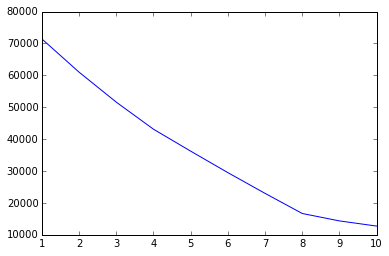

In [116]:
# graph inertia as clusters increase
inertia = []
k = []

for i in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit(Xscale_new)
    k.append(i)
    inertia.append(km.inertia_)
plt.plot(k, inertia)

# elbow test around 8

In [117]:
km = KMeans(n_clusters=8)
km.fit_predict(Xscale_new)

array([2, 2, 6, ..., 6, 2, 0], dtype=int32)

In [118]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,8)}
pd.DataFrame(columns, index=X_new.columns)

,0,1,2,3,4,5,6,7
C(party)[3],-0.000,0.000,0.000,-0.000,0.000,1.000,0.000,0.000
C(party)[D],-0.000,0.500,1.000,-0.000,0.459,-0.000,-0.000,0.000
C(party)[I],0.000,0.000,-0.000,-0.000,-0.000,-0.000,1.000,-0.000
C(party)[L],-0.000,0.000,-0.000,1.000,-0.000,-0.000,-0.000,-0.000
C(party)[R],1.000,0.500,-0.000,-0.000,0.541,0.000,0.000,-0.000
C(party)[U],-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,1.000
C(race_type)[T.PRES],0.069,1.000,0.042,0.084,0.005,0.308,0.256,0.585
C(race_type)[T.SEN],0.152,0.000,0.133,0.140,0.230,0.183,0.149,0.031
C(incumbent)[T.1],0.000,0.500,-0.000,0.000,0.984,0.000,0.004,-0.000
amount,85487.825,292776446.000,100303.868,2301.492,1512491.911,246.057,9613.398,131.292


### Some interesting clusters here:
0. Republican, non-incumbent, about 85k donated, not running for Pres or Sen -- "House Republican Challengers" 
1. Even Dem. Rep., incumbents, 1M+ donated, many PACs donating -- "Incumbent Congressmen and Senators"
2. Democrats, non-incumbent, 1M donated, few PACs donating -- "House Democrat Challengers"
3. 3rd party, non-incumbent, little money, few PACs donating, running for Pres. -- "3rd Party Longshots"
4. Even Dem. Rep., 50% incumbent, nearly 300M donated, many PACS donating -- "Romney vs. Obama" 
5. Unknown party, non-incumbent, running for Pres, no money and no donators -- "Deez Nuts"  
6. Libertarian, non-incumbent, 2k donated, few donators -- "Libertarian Challengers"
7. Independent, non-incumbent, over 9k donated, run for Pres and Sen -- "Independent Hopefuls"

In [119]:
full['clusters'] = km.labels_

In [147]:
full.clusters.value_counts()

0    2306
2    1721
4     575
5     530
6     503
3     250
7      65
1       2
dtype: int64

In [120]:
# Model 3
y_cluster, X_cluster = dmatrices('win ~ 0 + amount + pac_id_unique + pac_id_total + C(party) + C(race_type) + C(incumbent) + C(clusters)',
                                full, return_type='dataframe')

y_cluster = np.ravel(y_cluster)

In [121]:
Xcluster_scale = scale.fit(X_cluster).transform(X_cluster)

In [122]:
rf3 = rf 
svm3 = svm
dc3 = dc

rf3.fit(X_cluster, y_cluster)
svm3.fit(Xcluster_scale, y_cluster)
dc3.fit(X_cluster, y_cluster)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [123]:
print np.abs(cross_val_score(rf3, X_cluster, y_cluster, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(svm3, Xcluster_scale, y_cluster, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(dc3, X_cluster, y_cluster, scoring='precision', cv=10)).mean()

0.834842698782
0.828651522978
0.0682761255184


In [124]:
# Clustering didn't improve my model. Random Forest and SVM yield nearly the same precision of 83% vs a Dummy Classifier
# of 8% precision

In [125]:
# feature importance of last model
pd.set_option('display.float_format', lambda x: '%3f' % x)
d2 = {'importance': rf3.feature_importances_}
pd.DataFrame(d2, index=X_cluster.columns).sort('importance')

,importance
C(party)[U],0.000000
C(clusters)[T.7],0.000000
C(clusters)[T.3],0.000010
C(party)[L],0.000024
C(clusters)[T.5],0.000196
C(clusters)[T.1],0.000257
C(party)[3],0.000296
C(clusters)[T.6],0.000624
C(party)[I],0.000635
C(race_type)[T.PRES],0.001912


In [126]:
# use logistic regression to be able to speak about % effects of features on election outcome
# Model 4
lr = LogisticRegression()
lr.fit(Xcluster_scale, y_cluster)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [127]:
print np.abs(cross_val_score(lr, Xcluster_scale, y_cluster, scoring='precision', cv=10)).mean()

0.830417878925


In [128]:
lr1 = lr
lr1.fit(Xscale_new, y_new)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [129]:
print np.abs(cross_val_score(lr1, Xscale_new, y_new, scoring='precision', cv=10)).mean()
# Sometimes the simplest model is the best

0.844497547991


In [130]:
# make a dataframe to view the coefficients of the model
dlr = {'Coefficients': np.exp(lr1.coef_[0]), 'Features': X_new.columns}
pd.DataFrame(dlr, columns=['Coefficients', 'Features'])

,Coefficients,Features
0,0.578715,C(party)[3]
1,1.515886,C(party)[D]
2,0.865439,C(party)[I]
3,0.638726,C(party)[L]
4,1.243240,C(party)[R]
5,0.838330,C(party)[U]
6,0.455315,C(race_type)[T.PRES]
7,0.352718,C(race_type)[T.SEN]
8,2.316704,C(incumbent)[T.1]
9,1.139314,amount


In [131]:
# Incumbency and the number of PACs donating 
# to a campaign are majorly important in predicting election outcome. 
# As the number of unique PACs donating to a campaign increase by 1 standard deviation, the odds of that candidate 
# winning the election increase over 3x. Incumbents have a huge advantage at winning an election-- incumbents have
# over a 2x better chance of winning just by virtue of already holding office 

In [132]:
# control for each race_type, since results may be muddled by inclusion of all three in models
# make binary columns for each race type
def pres(x):
    if 'PRES' in x:
        return 1
    else:
        return 0

def sen(x):
    if 'SEN' in x:
        return 1
    else: 
        return 0
    
def house(x):
    if 'HOUSE' in x:
        return 1
    else:
        return 0

In [133]:
full['pres'] = full['race_type'].apply(pres)
full['sen'] = full['race_type'].apply(sen)
full['house'] = full['race_type'].apply(house)

In [134]:
# Use best model pre-clustering as I may want to cluster again controlling for race type
# Model 5

y_pres, X_pres = dmatrices('win ~ 0 + amount + pac_id_unique + pac_id_total + C(party) + C(incumbent) + C(pres)',
                         full, return_type='dataframe')
y_pres = np.ravel(y_pres)

In [135]:
Xpres_scale = scale.fit(X_pres).transform(X_pres)

In [136]:
rf4 = rf
dc4 = dc
svm4 = svm 
lr2 = LogisticRegression()

rf4.fit(X_pres, y_pres)
svm4.fit(Xpres_scale, y_pres)
lr2.fit(Xpres_scale, y_pres)
dc4.fit(X_pres, y_pres)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [137]:
print np.abs(cross_val_score(rf4, X_pres, y_pres, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(dc4, X_pres, y_pres, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(svm4, Xpres_scale, y_pres, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(lr2, Xpres_scale, y_pres, scoring='precision', cv=10)).mean()

0.825789469602
0.0927424082869
0.781160788589
0.813519832506


In [138]:
#RF performs best, but about the same as when all three race types are included.
#try again controlling for SEN and HOUSE

#Model 6
y_sen, X_sen = dmatrices('win ~ 0 + amount + pac_id_unique + pac_id_total + C(party) + C(incumbent) + C(sen)',
                         full, return_type='dataframe')
y_sen = np.ravel(y_sen)

In [139]:
Xsen_scale = scale.fit(X_sen).transform(X_sen)

In [140]:
rf5 = rf
dc5 = dc
svm5 = svm 
lr3 = lr2

rf5.fit(X_sen, y_sen)
svm5.fit(Xsen_scale, y_sen)
lr3.fit(Xsen_scale, y_sen)
dc5.fit(X_sen, y_sen)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [141]:
print np.abs(cross_val_score(rf5, X_sen, y_sen, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(dc5, X_sen, y_sen, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(svm5, Xsen_scale, y_sen, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(lr3, Xsen_scale, y_sen, scoring='precision', cv=10)).mean()

0.837510859255
0.0881986184532
0.834884845357
0.845585210329


In [142]:
#Again not much improvement when controlling for just senatorial races
#See if there's a differnece for house races, though I think there won't be

#Model 7

y_house, X_house = dmatrices('win ~ 0 + amount + pac_id_unique + pac_id_total + C(party) + C(incumbent) + C(house)',
                         full, return_type='dataframe')
y_house = np.ravel(y_house)

In [143]:
Xhouse_scale = scale.fit(X_house).transform(X_house)

In [144]:
rf6 = rf
dc6 = dc
svm6 = svm 
lr4 = lr2

rf6.fit(X_house, y_house)
svm6.fit(Xhouse_scale, y_house)
lr4.fit(Xhouse_scale, y_house)
dc6.fit(X_house, y_house)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [145]:
print np.abs(cross_val_score(rf6, X_house, y_house, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(dc6, X_house, y_house, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(svm6, Xhouse_scale, y_house, scoring='precision', cv=10)).mean()
print np.abs(cross_val_score(lr4, Xhouse_scale, y_house, scoring='precision', cv=10)).mean()

0.835970139315
0.106568412848
0.838040854894
0.844497547991


In [146]:
#With these results, I'm satisfied that variables that effect election outcome are the same for all race types